# Caso Financiero - Banco de Colombia

## Equipo

-   Hernán Carmelo Cavadias Martinez

-   Miguel Angel Malagón Romero

-   David Santiago Buitrago Norato
    
-   Duvan Santiago Castro Bolivar

## Business Understanding 

**¿Qué es una tarjeta de crédito?**

Una tarjeta de crédito es un instrumento usado por personas naturales y jurídicas que les permiten acceder rápidamente al crédito.
 
**¿Cómo funcionan?**

Los bancos otorgan las tarjetas a personas asignando un cupo limite que pueden usar, este cupo basado en diversas características de cada persona. 
 
**¿Cómo ganan los bancos?**

-   Cuotas de manejo: Una cuota mensual que el propietario de la tarjeta le paga al banco por el uso de la tarjeta.
-   Intereses corrientes: algunas tarjetas generan intereses desde el momento de la compra hasta el momento en el que el usuario realiza el pago.
-	Intereses de mora: Intereses que se generan después de la fecha límite de pago 
-	Comisiones de comercio: Los comercios deberán pagar un porcentaje de la venta al momento de hacer una venta con tarjeta 
 
**¿Qué son y cómo funcionan las franquicias?**

- Las franquicias son una red de procesamiento de pagos, aunque no emiten tarjetas directamente a los consumidores en su lugar proporcionan la infraestructura para que se emitan las tarjetas y procesen transacciones 

**Principales bancos Colombianos (participación de mercado)** 

- 	Bancolombia 26.5%
- 	Davivienda 16.5%
- 	Banco de Bogotá 11.8%
- 	BBVA 10.6%
- 	Banco de Occidente 6.2%

**Objetivo del negocio**

-	Aumentar el volumen de tarjetas de crédito en el mercado

**Criterio de éxito**

Al aumentar el volumen de tarjetas de crédito es aún más rentable si se consiguen personas con las siguientes características:
-	Historial crediticio sólido: Un cliente de pagar sus deudas a tiempo es atractivo
-	Estabilidad financiera: Una situación laboral estable, ingresos regulares y relación saludable entre ingresos / gastos 
-	Uso regular de la tarjeta: Uso regular de la tarjeta, genera comisiones al banco 
-	Mantener un saldo, pero pagar el mínimo: es rentable una persona que además de usar la tarjeta de crédito regularmente, mantenga un saldo y pague el mínimo, le hace ganar al banco por el concepto de comisiones de mora, el banco gana por comisiones de compra y además reduce un poco el riesgo al pagar el valor mínimo de pago 
-	No supera su límite de crédito: es amigable una persona que maneje su riesgo de crédito y no supere su límite de crédito 
-	Historial de trabajo y residencia estable 
-	Bajo nivel de endeudamiento 
-	Años de historial crediticio 
-	Diversidad en tipos de crédito 

**Objetivo de la minería de datos:**
-	Poder identificar los diferentes tipos de clientes que posee la empresa, para hacer promociones eficientemente

**Criterio de éxito de la minería de datos**
-	Identificación clara de los grupos de clientes
-	Identificación de hábitos de consumo 
-	Identificación de posibles usuarios riesgosos (personas que por sus hábitos puede ser mejor no ofrecerles promociones)



## Data understanding

### Data exploration

Para la exploración de datos decidimos separar los registros en función del sitio preferido de los clientes, pues graficar en función de cada registro resulta inviable por la cantidad que tenemos y además carente de significado para el análisis, en cambio, los sitios preferidos si nos dan una visión significativa para las demás variables que tenemos. Por lo tanto será así como exploremos los datos y los trabajemos más adelante, como forma de exploración hicimos previamente un gráfico de barras donde se representa el valor total de compras en cada comercio usando visas en territorio nacional:

(Imagen4.png)

Aquí vemos entonces que los clientes del banco usan mayormente sus tarjetas para comprar en SUPERMERCADOS Y TIENDAS EXPRESS, ALMACEN POR DEPARTAMENTO CON SUPERMERCADO, ALMACENES DE VESTUARIO Y ACCESORIO PARA LA FAMILIA, ALMACENES DE CALZADO, etc.

Este modo de ver la información nos resulta particularmente útil para poder sugerir al banco que tipo de promociones lanzar, pues podremos determinar que combinación de variables resultará más efectiva por la cantidad de clientes interesados en aprovecharlas gracias a esta observación y análisis de su comportamiento.

### Data quality

No encontramos errores para corregir en la base de datos en sí, sin embargo hay varibles que no serán tomadas en cuenta para el desarrollo del análisis de los datos por su carencia de significado para el mismo, tal como el grupo del cliente, el mínimo, máximo y desviación estándar de las compras, porcentaje nacional e internacional total, debido a que ya tenemos la misma información con las franquicias y de los sitios de consumo excluiremos "SIN NOMBRE".

## Data preparation

Primero, importamos la librerías que nos serán útiles para el desarrollo del proyecto:

In [1]:
import pandas as pd
import hvplot.pandas
import matplotlib.pyplot as plt
import seaborn as sns
from path import Path
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

Importamos los datos contenidos en el documento de excel infobanca.xlsx

In [2]:
infobanca_original= pd.read_excel('infobanca.xlsx')
infobanca = infobanca_original

### Data construction

Ahora creamos columna de total de ventas multiplicando el promedio por transacción por el número de transacciones con el fin de tener un número total aproximado del consumo de cada uno de los usuarios:

In [3]:
infobanca['Total_ventas']=infobanca['promedio_por_transaccion']*infobanca['Numero_de_transacciones']

### Data cleaning

Eliminamos las columnas mencionadas previamente en el reporte de calidad de los datos y además eliminamos la columna del promedio por transacción, pues al tener el total consumido por cada usuario, no lo necesitamos de ahora en adelante. Eliminamos también los registros de usuarios cuyo sitio preferido haya sido "SIN NOMBRE":

In [4]:
coldt=['CLIENTE','grupo_de_cliente','Numero_de_transacciones','promedio_por_transaccion','transaccion_minima','transaccion_maxima','desviacion_estandar_por_transaccion','porcentaje_nacional_total','porcentaje_internacional_total']
infobanca= infobanca.drop(coldt, axis=1)
infobanca= infobanca[infobanca['Sitio_consumo_masfrecuente'] !='SIN NOMBRE']

### Data formatting

Multiplicamos total venta por los porcentajes del DF con el fin de deshacernos de los porcentajes y en vez de eso tener valores netos en pesos colombianos de las ventas hechas con cada franquicia, hora del día, etc.

In [5]:
colum = list(infobanca.columns)
colum.remove('Sitio_consumo_masfrecuente')
colum.remove('Total_ventas')
for i in colum:
  infobanca[i] = infobanca[i]*infobanca['Total_ventas']

Ahora cambiamos la forma de la base de datos, pues en vez de tener un cliente en cada fila, tendremos cada uno de los sitios y las variables que quedarán registradas serán las sumatorias del total de dinero invertido en cada sitio bajo cada criterio, tal como las compras con visa nacional o internacional, la hora del día de la transacción, etc.

Esta será la base de datos con las que iniciemos la preparación de los datos para la aplicación del metodo de clustering K-means.

In [6]:
columnas=list(infobanca.columns.values)
columnas.remove('Total_ventas')
suma_por_sitio=infobanca.groupby('Sitio_consumo_masfrecuente')[columnas].sum()
infobanca=suma_por_sitio

Para un mejor análisis y lectura de los datos vamos a simplificar la información dejándola en **MILLONES**

In [7]:
colum= infobanca.columns
for i in colum:
    infobanca[i]=infobanca[i]/1000000
infobanca=round(infobanca,2)


In [8]:
nuevos = ['visa_nacional', 'visa_internacional','mastercard_nacional', 'mastercard_internacional','otrafranquicia_nacional',
       'otrafranquicia_internacional', 'manana','tarde', 'noche', 'DOMINGO', 'LUNES','MARTES', 'MIERCOLES', 'JUEVES', 
        'VIERNES','SABADO']
infobanca.columns = nuevos

### Escalar datos

Escalamos la base de datos con standard sca `StandardScaler` para normalizar los datos y creamos el índice `Sitio_consumo_masfrecuente`

In [9]:
infobanca_escalado=StandardScaler().fit_transform(infobanca)

# DataFrame con los datos escalados
df_infobanca_scaled = pd.DataFrame(
    infobanca_escalado,
    columns=infobanca.columns
)
# Copiamos los nombres de los sitios
df_infobanca_scaled["Sitio_consumo_masfrecuente"] = infobanca.index

# Establecer la columna Sitio_consumo_masfrecuente como índice
df_infobanca_scaled= df_infobanca_scaled.set_index("Sitio_consumo_masfrecuente")

# Modelling

## Select Modelling Techniques

Recordando nuestro objeto de estudio, buscamos a través de grupos poblacionales agrupados por sitio donde más frecuentan sus compras, presentar posibles promociones que benefician a nuestros clientes, a través del medio de pago que emplean en dichos sitios. 

Ahora bien, dado que necesitamos sugerir las promociones para los individuos, estas estarán representadas por sitios, recordando que la base de datos fue ajustada de esa manera anteriormente. Teniendo en cuenta que las promociones se harán de acuerdo con las variables que tenemos como tipos de tarjetas, franjas horarias o dias de la semana, la metodología que vamos a emplear será K-Means, en donde el algoritmo nos permitirá identificar los puntos que más tengan similitud. 

Sabiendo que esta metodología necesita un K optimo donde minimiza la varianza entre puntos y la maximiza entre centroides, agrupandolos de acuerdo a dicho K, partimos de los datos originales para hallar este K, primero tomamos números del 1 al 15, con los que trazaremos los valores de inercia y poder hallar el k óptimo para los clusters.


## Build Model

El modelo que vamos a utilizar será K-Means, ahora bien, como lo mencionamos anteriormente, este algoritmo tiene dos parámetros importantes, el primero el K que vamos a emplear, el cual será seleccionado bajo el método de codo, el cual utiliza la distancia media de las observaciones a su centroide. En otras palabras, busca fijar las distancias intra-cluster, en donde a medida que el K es mayor la varianza tiende a disminuir, lo que significaría que los clústeres son más compactos.

### Método de codo

In [10]:
k = list(range(1,15))

In [11]:
# Crear una lista vacía para almacenar los valores de inertia
inertia = []

In [12]:
# Bucle for para calcular la inercia de cada K
for i in k:
    model = KMeans(n_clusters = i, random_state = 0)
    model.fit(df_infobanca_scaled)
    inertia.append(model.inertia_)

In [13]:
# Crear un diccionario con los datos para trazar la curva del Codo
elbow_data_original = {
    'k': k,
    'inertia': inertia
}

# Crea un DataFrame con los datos para trazar la curva del Codo
df_elbow_data_original = pd.DataFrame(elbow_data_original)

In [14]:
# Observamos los valores de inercia en un gráfico de línea para encontrar el K óptimo

elbow_plot_original = df_elbow_data_original.hvplot.line(
    title = 'Elbow Plot: Original Data',
    x = 'k', xlabel = 'k', xticks = k,
    y = 'inertia', ylabel = 'Inertia',
    height=250, width=500
)
elbow_plot_original

:Curve   [k]   (inertia)

A partir del gráfico, el mejor valor de K parece ser el K=6, el cual será el parametro a utilizar como número de clusteres que se formaran.

### Clusters ~ K-Means

Ahora armaremos clusters de los sitios de consumo más frecuentes usando el K=6 que encontramos en el paso anterior.

In [15]:
# Inicializar el modelo K-Means usando el mejor valor para k
model = KMeans(n_clusters=6)
model.fit(df_infobanca_scaled) # Ajuste del modelo

KMeans(n_clusters=6)

In [16]:
# Prediga los grupos para agrupar los sitios de consumo usando los datos escalados
clusters_original = model.predict(df_infobanca_scaled)
clusters_original

array([0, 1, 0, 0, 4, 0, 0, 1, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0,
       0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0])

In [17]:
# Crear una copia del DataFrame
df_clusters_original = infobanca.copy()

Una vez tenemos los Clusteres que vamos a asignara a las observaciones (sitios), vamos a pegar ese vector columna con dicha información con nuestra base de datos original.

In [18]:
# Agregue una nueva columna al DataFrame con los grupos predichos
df_clusters_original['Cluster'] = clusters_original

In [19]:
cluster_plot_original = df_clusters_original.hvplot.scatter(
    title='Cluster Plot: Datos originales',
    x = 'mastercard_nacional', xlabel = 'mastercard_nacional',
    y = 'DOMINGO',ylabel = 'DOMINGO', by = 'Cluster',hover_cols=["Sitio_consumo_masfrecuente"],
    height=250, width=500
)
cluster_plot_original

:NdOverlay   [Cluster]
   :Scatter   [mastercard_nacional]   (DOMINGO,Sitio_consumo_masfrecuente)

### Optimizar clústeres con análisis de componentes principales

Otra metodología que se puede utilizar con el fin de contrastar los resultados del modelamiento anterior es la optimización de los clústeres, pero bajo un análisis de componentes principales, antes de correr el modelo. Este método lo que nos permitirá será reducir las variables que tengamos a un número definido a discreción del investigador, en este caso dado que tenemos 3 categorías en las que podemos agrupar toda la información (Tipo de tarjeta por franquicias, franja horaria, Noche o Día y dias de la semana) el número de componentes principales será 3.

In [20]:
pca_model = PCA(n_components=3) #Creación del algoritmo
pca_data = pca_model.fit_transform(df_infobanca_scaled) # Reducción a tres CP
pca_data[:5]

array([[-1.47392774, -0.05125033, -0.04254504],
       [11.01384135,  2.82308676, -0.63776749],
       [-1.29306492, -0.0518408 , -0.04859666],
       [-1.47486316, -0.05086348, -0.04259199],
       [ 3.51468205, -0.34977738,  0.19919799]])

Dado que ya tenemos los datos reducidos a tres componentes principales vamos a crear un DataFrame que los contenga. 

In [21]:
df_pca_data = pd.DataFrame(pca_data)
df_pca_data["Sitio_consumo_masfrecuente"] = infobanca.index
df_pca_data = df_pca_data.set_index('Sitio_consumo_masfrecuente')

# Mostrar datos de muestra
df_pca_data.head(5)

,0,1,2
Sitio_consumo_masfrecuente,,,
"ADMINISTRACION DE AREAS COMUNES, SERVICIOS DE LIMPIEZA, MANTENIMIENTO Y CELADURIA",-1.473928,-0.051250,-0.042545
AEROLINEAS,11.013841,2.823087,-0.637767
AGENCIAS DE BOLETERIA ( Producciones de Teatro ) excepto cine,-1.293065,-0.051841,-0.048597
AGENCIAS DE PROTECCIÓN Y SERVICIOS DE SEGURIDAD,-1.474863,-0.050863,-0.042592
AGENCIAS DE VIAJE y OPERADORES DE TURISMO,3.514682,-0.349777,0.199198


Una vez tenemos los datos bajo la metodologia ACP (Analisis de componentes principales), vamos a utilizar estos datos para calcular el K óptimo que se requiere a la ahora de correr nuestro modelo K-Means

In [22]:
inertia2 = []
for i in k:
    kmeans_model_pca = KMeans(n_clusters=i, random_state=1)
    kmeans_model_pca.fit(df_pca_data)
    inertia2.append(kmeans_model_pca.inertia_)

In [23]:
elbow_data_pca = {
    'k': k,
    'inertia':inertia2
}
df_elbow_data_pca = pd.DataFrame(elbow_data_pca)

In [24]:
elbow_plot_pca = df_elbow_data_pca.hvplot.line(
    title='Elbow Plot: PCA',
    x = 'k', xticks = k,xlabel = 'k',
    y = 'inertia',ylabel = 'inertia',
    height=250,width=500
)
elbow_plot_pca

:Curve   [k]   (inertia)

Teniendo en cuenta la gráfica de codo utilizando los datos calculados por componentes principales, notamos que tiene una similitud a la gráfica con los datos originales, por lo que seguiremos utilizando el mismo K, que en este caso será K = 6. 

In [25]:
kmeans_model_pca = KMeans(n_clusters=6)
kmeans_model_pca.fit(df_pca_data)

KMeans(n_clusters=6)

In [26]:
clusters_pca = kmeans_model_pca.predict(df_pca_data)

In [27]:
df_clusters_pca = infobanca.copy() #DataFrame PCA
df_clusters_pca['Cluster'] = clusters_pca

In [28]:
cluster_plot_original2 = df_clusters_pca.hvplot.scatter(
    title='Cluster Plot: datos_pca',
    x = 'mastercard_nacional', xlabel = 'mastercard_nacional',
    y = 'DOMINGO', ylabel = 'DOMINGO', by = 'Cluster', hover_cols=["Sitio_consumo_masfrecuente"],
    height=250, width=500
)
cluster_plot_original2

:NdOverlay   [Cluster]
   :Scatter   [mastercard_nacional]   (DOMINGO,Sitio_consumo_masfrecuente)

Al hacer una comparación entre los gráficos, notamos que no existe una diferencia a la hora de utilizar la base de datos original y la de componentes principales, dado que utilizamos los mismo K óptimos.

## Evaluación 

Por lo que hemos observado al cambiar los ejes del gráfico de dispersión de los clusters, vemos que el modelo que hemos desarrollado es valido para conseguir los objetivos del negocio, pues este nos permite observar fácilmente el comportamiento de los clientes del banco con sus tarjetas bajo ciertos criterios al permitirnos ver, por ejemplo, el nivel de consumo que tienen los clientes en las aerolíneas cuando es de noche y usan su tarjeta visa en compras nacionales, es decir, el nivel de uso de las tarjetas de los clientes para comprar vuelos nacionales en horas de la noche, que en este caso específico es particularmente alto, lo que es una combinación de variables útil para lanzar una promoción en alianza con aerolíneas y también nos deja ver el nivel de elasticidad de consumo de los comercios, pues vimos que bajo gran parte de las circunstancias que probamos el comercio que resalta sobre todos es el de supermercados, que concuerda con lo que es de esperarse, debido a la dependencia que tenemos de ellos para proveernos de nuestros alimentos, lo cual puede llevar a pensar también que cualquier alianza con una cadena de supermercados para lanzar una promoción tiene una gran probabilidad de ser exitosa.

Por esto, aprobamos el modelo de clustering con k-medias y puede ser usado para hacer recomendaciones de promociones con un importante mercado potencial al banco, lo cual va en línea con sus objetivos.

### Resultados

#### Interpretación Clústeres

In [41]:
cluster = pd.Series(model.labels_, index =infobanca.index)
#for key, item in cluster.groupby(cluster):
    #print(key,': ',', '.join(item.index))
    #print()
# Comentado por output ser demasiado extenso

Como vemos, en los 6 Clústeres que tenemos podemos ver que en el cluster cero, se encuentra en su gran mayoria sitios relacionados con la prestación de servicios, el primero es más especifico pero podemos catalogarlo como sitios de consumo masivo, tales como los supermercados o tiendas de ropa, el segundo actividades profesional, tercero supermercados, en el cuarto cluster vemos 3 subgrupos, activiades relacionadas con el turismo, los juegos del azar y actividades relacionadas con la educación, finalmente el cluster 5 con compras en internet. 

#### Posibles promociones por Clústeres

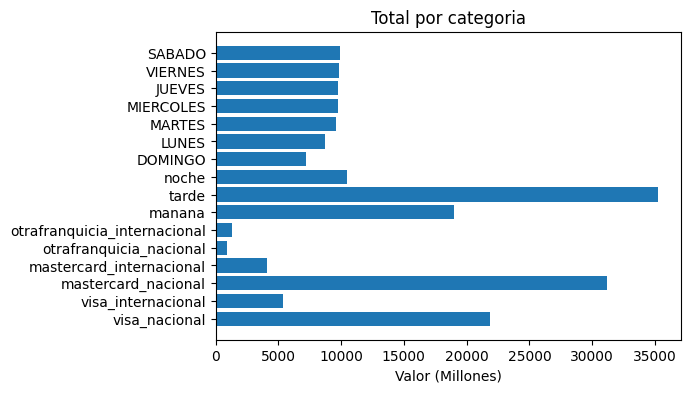

In [30]:
totales = infobanca.sum().reset_index()
totales.columns = ['Tipo', 'Total']
df_totales = pd.DataFrame(totales)

plt.figure(figsize=(6, 4))  # Tamaño opcional del gráfico
plt.barh(df_totales['Tipo'], df_totales['Total'])
plt.xlabel('Valor (Millones)')
plt.title('Total por categoria')
plt.show()

A partir de la gráfica anterior podemos notar que entre las franquicias que tienen un mayor valor transaccional son las de MasterCard y visa nacional, por otra parte, en las franjas horarias, durante la mañana y la tarde son los momentos donde más transacciones se tienen es decir entre las 6 a.m y 6 p.m, siendo la franja de la tarde en la que hay mayores transacciones y finalmente el Sábado y viernes son los día que marginalmente tienen mayores transacciones.

Text(0.5, 1.0, 'Correlación entre variables')

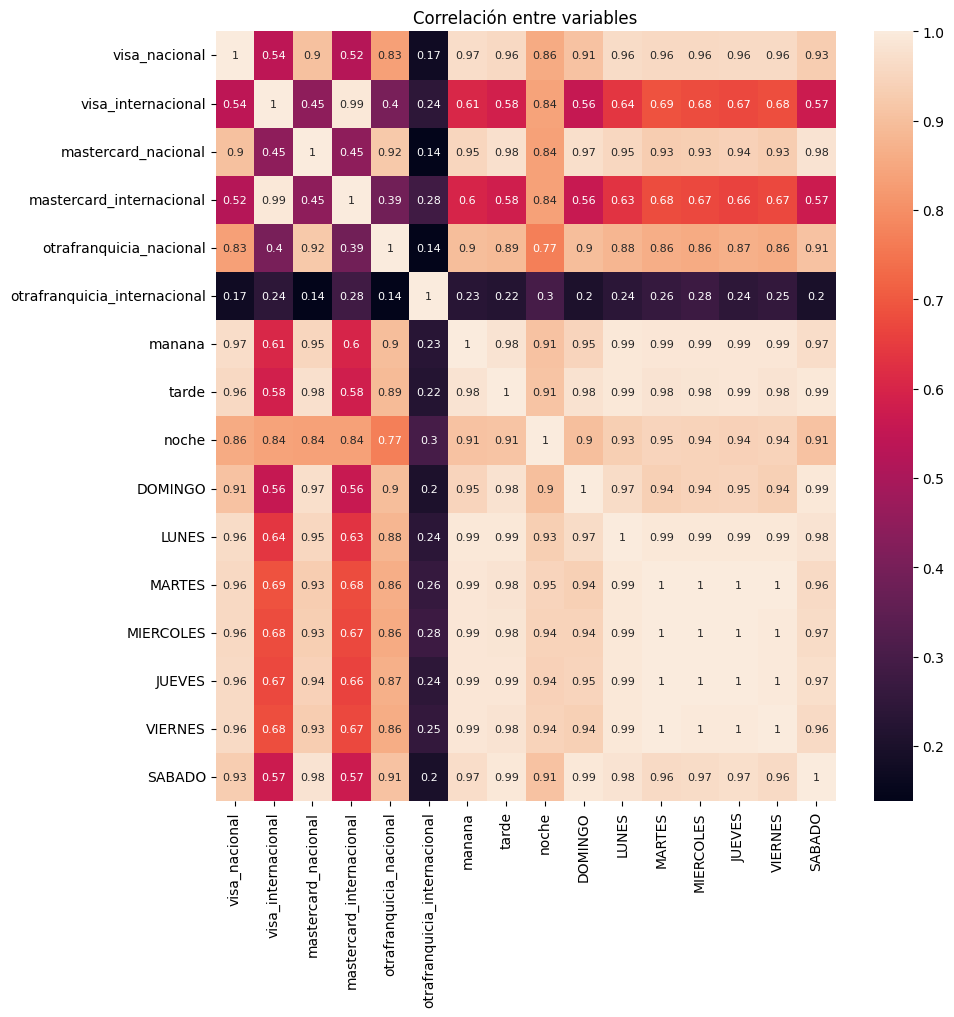

In [31]:
plt.figure(figsize=(10, 10))
sns.heatmap(df_clusters_original.drop('Cluster', axis=1).corr(),annot = True,
            annot_kws = {'size': 8})
plt.title("Correlación entre variables")

**Análisis de Correlación para posibles promociones:**

**Tipo de tarjeta, día y franja horaria**

Una posible oferta podría ser para clientes con tarjetas visa que compren en cualquier día de la semana de lunes a viernes a excepción del sábado y Domingo. En cambio, para los clientes con MasterCard los sábados y Domingos podrían ser más atractivas las promociones. En cuanto a la franja Horaria, la mañana y tarde para cualquier día, pero en especial, un sábado en la tarde.


In [32]:
def cluster_plot(x,y,titulo):
    cluster_plot_original = df_clusters_original.hvplot.scatter(
    title=titulo,
    x = x, xlabel = x,
    y = y,ylabel = y, by = 'Cluster',hover_cols=["Sitio_consumo_masfrecuente"],
    height=250, width=500)
    return cluster_plot_original

##### Clientes con tarjeta visa Nacional  que compran el día viernes

In [33]:
cluster_plot('VIERNES','visa_nacional','Cluster: Visa - Viernes ') 

:NdOverlay   [Cluster]
   :Scatter   [VIERNES]   (visa_nacional,Sitio_consumo_masfrecuente)

El banco podría ofrecer promociones para aquellos clientes que tengan Visa y hagan transacciones los viernes en supermercados y tiendas express, así como para los clientes del clúster 1 (sitios de consumo masivo), en donde la oferta no debe ser tan alta dado que son lo que más utilizan la tarjeta. A lo que debería centrarse en ofrecer ofertas/promociones para los clústeres cero y 2, dado que su uso no es tan significativo.

##### Clientes con tarjeta visa Nacional que compran en la mañana

In [34]:
cluster_plot('manana','visa_nacional','Cluster: Visa - Mañana ') 

:NdOverlay   [Cluster]
   :Scatter   [manana]   (visa_nacional,Sitio_consumo_masfrecuente)

Contrastándolo con el anterior los clústeres siguen la misma conformación al cambiar a interacción del tipo de tarjeta con el día.

##### Clientes con tarjeta visa Nacional que compran en la tarde

In [35]:
cluster_plot('tarde','visa_nacional','Cluster: Visa - tarde ') 

:NdOverlay   [Cluster]
   :Scatter   [tarde]   (visa_nacional,Sitio_consumo_masfrecuente)

Podemos concluir que el banco puede llegar a generar promociones para los clientes de los diferentes clústeres que utilicen la tarjeta visa de manera indiferente entre la franja horaria de la mañana y la tarde, cualquier día de la semana a excepción del sábado y domingo.

##### Clientes con tarjeta Mastercard Nacional que compran un Sábado

In [36]:
cluster_plot('SABADO','mastercard_nacional','Cluster: Mastercard - Sabado ')

:NdOverlay   [Cluster]
   :Scatter   [SABADO]   (mastercard_nacional,Sitio_consumo_masfrecuente)

##### Clientes con tarjeta Mastercard Nacional  que compran un domingo

In [37]:
cluster_plot('DOMINGO','mastercard_nacional','Cluster: Mastercard Nacional - Domingo')

:NdOverlay   [Cluster]
   :Scatter   [DOMINGO]   (mastercard_nacional,Sitio_consumo_masfrecuente)

##### Clientes con tarjeta Mastercard Nacional  que compran en la tarde

In [38]:
cluster_plot('tarde','mastercard_nacional','Cluster: Mastercard Nacional - Tarde')

:NdOverlay   [Cluster]
   :Scatter   [tarde]   (mastercard_nacional,Sitio_consumo_masfrecuente)

Al contratar los tres gráficos anteriores, el banco podria pensar en una serie de promociones para los clientes que utilicen la tarjeta Mastercad Nacional, los fines de semana, en la tarde. 

##### Clientes que compran el Sábado en la tarde

In [39]:
cluster_plot('tarde','SABADO','Cluster: Sábado - Tarde')

:NdOverlay   [Cluster]
   :Scatter   [tarde]   (SABADO,Sitio_consumo_masfrecuente)

Finalmente, mostramos que los clientes que se encuentran dentro del clúster 0, son lo que deben tener un mayor dinamismo a través de las promociones con el fin de incentivar el uso de la tarjeta, en los días en donde más los diferentes clústeres como el 3 tienen mayor uso de las tarjetas.